In [1]:
import numpy as np
from PIL import Image, ImageDraw
import time
from random import sample
import numpy.random as random

In [21]:
class GridWorld:
    def __init__(self, board_dims, start_state, terminal_state, reward_matrix):
        self.board_dims = board_dims
        self.height, self.width = board_dims
        self.start_state = start_state
        self.agent_pos = start_state
        self.terminal_state = terminal_state
        self.reward_matrix = reward_matrix
        self.moves = [(-1,0),(0,-1),(1,0),(0,1)] #up,left,down,right
        
    def get_moves(self, point):
        """
        point - the point our agent is in
        This function obtains the points of possible moves you can potentially make from the point provided
        """
        
        return [tuple(np.array(point)+np.array(x)) for x in self.moves]

    def point_to_index(self, point):
        """
        point - the point we want to convert to index (for list of lists e.g.)
        This function obtains the index when you iterate across each column over each row of our game board
        """
        return point[0]*self.width + point[1]

    def index_to_point(self, index):
        """
        index - the index we want to convert to game square point
        This function obtains the index when you iterate across each column over each row of our game board
        """
        #(divisions, remainder)
        return (index // self.width, index % self.width)

    def get_reward(self,point):
        """
        point - a point in our grid
        This function returns the reward for our agent going to the state represented by point
        """
        return self.reward_matrix[point]
    
    def illegal_move(self,point):
        """
        point - a point that may or may not be in our grid
        This function returns true if the move we make takes us off the board and false if the move is legal
        """
        return True if ((point[0] < 0 or point[0] == self.height) or (point[1] < 0 or point[1] == self.width)) else False
        
    def print_board(self):
        print(self.reward_matrix)

In [22]:
class Targeting_Game(GridWorld):
    def __init__(self, board_dims, start_state, terminal_state, reward_matrix):
        GridWorld.__init__(self,board_dims, start_state, terminal_state, reward_matrix)
        
    def draw(self):
        """
        agent_pos - tuple point representing agent's current position on game board 
        remaining_prizes - list of tuples representing remaining prizes and their positions on game board
        This function draws our environment
        """

        image = Image.new("RGB", (501, 501), "black")
        draw = ImageDraw.Draw(image)

        w = 500/(self.width)
        h = 500/(self.height)
        color = "white"

        #Draw Grid and Start/Stop Squares
        for i in range(self.height):
            for j in range(self.width):
                if(i == self.start_state[0] and j == self.start_state[1]):
                    color = "blue"
                elif(i == self.terminal_state[0] and j == self.terminal_state[1]):
                    color = "red"
                draw.rectangle(((0+j*w, 0+i*h),(w+j*w, h+i*h)), outline = "black", fill = color)
                color ="white"

        #Draw Agent
        draw.ellipse((self.agent_pos[1]*w + w/4, self.agent_pos[0]*h + h/4, 3*w/4 + self.agent_pos[1]*w, 3*h/4 + self.agent_pos[0]*h), fill="black")

        display(image)

    def update_state(self,new_pos):
      """
      new_pos - a point in the game grid that the agent has moved to
      This function updates the agent position for the GameGrid class variable.
      """
      self.agent_pos = new_pos

    def refresh_game(self):
        self.agent_pos = self.start_state

In [23]:
class Collection_Game(GridWorld):
    def __init__(self, board_dims, start_state, prize_states, reward_matrix, prize_value=0):
        GridWorld.__init__(self,board_dims, start_state, None, reward_matrix)
        self.prize_states = prize_states
        self.remaining_prize_states = list(prize_states)
        self.prize_value = prize_value
        for prize_state in prize_states:
            self.reward_matrix[prize_state] = prize_value
    
    def draw(self):
        """
        agent_pos - tuple point representing agent's current position on game board 
        remaining_prizes - list of tuples representing remaining prizes and their positions on game board
        This function draws our environment
        """

        image = Image.new("RGB", (501, 501), "black")
        draw = ImageDraw.Draw(image)

        w = 500/(self.width)
        h = 500/(self.height)
        color = "white"

        #Draw Grid and Start/Stop Squares
        for i in range(self.height):
            for j in range(self.width):
                if(i == self.start_state[0] and j == self.start_state[1]):
                    color = "blue"
                draw.rectangle(((0+j*w, 0+i*h),(w+j*w, h+i*h)), outline = "black", fill = color)
                color ="white"

        #Draw Agent
        draw.ellipse((self.agent_pos[1]*w + w/4, self.agent_pos[0]*h + h/4, 3*w/4 + self.agent_pos[1]*w, 3*h/4 + self.agent_pos[0]*h), fill="black")

        #Draw Prizes
        if len(self.remaining_prize_states) > 1:
            for x in self.remaining_prize_states:
                draw.rectangle(((x[1]*w + w/4, x[0]*h + h/4), (3*w/4+x[1]*w, 3*h/4+x[0]*h)), outline = "black", fill = "yellow")
        elif len(self.remaining_prize_states) == 1:
            remaining_prize = self.remaining_prize_states[0]
            draw.rectangle(((remaining_prize[1]*w + w/4, remaining_prize[0]*h + h/4), (3*w/4+remaining_prize[1]*w, 3*h/4+remaining_prize[0]*h)), outline = "black", fill = "yellow")
      
        display(image)

    def update_state(self,new_pos):
        """
        new_pos - a point in the game grid that the agent has moved to
        This function updates the agent position for the GameGrid class variable.
        """
        self.agent_pos = new_pos
        if self.agent_pos in self.remaining_prize_states:
            self.remove_prize(self.agent_pos)

    def remove_prize(self, prize_point):
        """
        prize_point - a point in the game grid that contained a prize
        This function removes the prize at the prize_point supplied from the remaining prizes. This function also
            updates the reward matrix accordingly.
        """
        #remove prize from remaining prizes
        self.remaining_prize_states.remove(prize_point)
        #adjust reward matrix to account for no prize at this prize_point for the rest of the episode
        self.reward_matrix[prize_point] = self.reward_matrix[self.start_state]
        #if there remains one prize, set that to be the terminal state for the episode
        if len(self.remaining_prize_states) == 1:
            self.terminal_state = self.remaining_prize_states[0]
        
    def refresh_game(self):
        """
        This function refreshes the game's agent position, the remaining prizes, the reward matrix, and terminal 
            state. This is used between each episode
        """
        self.agent_pos = self.start_state
        self.remaining_prize_states = list(self.prize_states)
        self.terminal_state = None
        
        for prize_state in self.prize_states:
            self.reward_matrix[prize_state] = self.prize_value

In [ ]:
class QTable:
    """
    STILL IN PROGRESS
    """
    def __init__(self, Game, alpha, epsilon):
        self.Game = Game
        self.matrix = np.zeros([Game.height*Game.width, len(Game.moves)])
        self.alpha = alpha
        self.epsilon = epsilon
        self.policy = np.ones(Game.board_dims) / len(Game.moves)
        
        
    def returnQTableActionFromState(self,state, moves, possible_moves):
        possible_moves_idx = [moves.index(possible_move) for possible_move in possible_moves]
        possible_move_idx = np.argmax(self.matrix[state,possible_moves_idx])

        return possible_moves[possible_move_idx]

    def updateQTable(self, epoch, listOfStatesAndActionsUsed):
        new_reward = 1/len(listOfStatesAndActionsUsed)
        for sa_pair in list(set(listOfStatesAndActionsUsed)):
            self.incidences[sa_pair[0],sa_pair[1]] += 1
            current_reward = self.matrix[sa_pair[0], sa_pair[1]]
            self.matrix[sa_pair[0], sa_pair[1]] = current_reward + (1 / self.incidences[sa_pair[0],sa_pair[1]]) * (new_reward - current_reward)
  
  

In [ ]:
class Agent:
    """
    STILL IN PROGRESS
    """
    def __init__(self, Game, model, policy):
        self.Game = Game
        self.model = model
        self.policy = policy #should be a matrix of probabilities
       
    def update_policy(self):
        model.update_policy
    
    def update_model(self):
        return None
    
    def observe_sprime(self):
        return None
    
    def get_action(self, state):
        
    
    def play_game(self, episodes):
        player_scores = []
        #number of times player plays the game is episodes.

        for i in range(episodes):
            #in each episode, the player needs to complete the task in T steps (t = 0,1,...,t-2,t-1,T)

            t = 0
            episode_reward = 0
            Game.draw()

            #while agent is not in a terminal state
            while Game.agent_pos != Game.terminal_state:
                if output:
                    print("Player's position",Game.agent_pos)

                t += 1

                #get possible moves going up, left, down, and right
                possible_moves = Game.get_moves(Game.agent_pos)
                #randomly select move
                r = random.randint(0,len(possible_moves))
                new_move = possible_moves[r]

                #if move is illegal (going off the board), set reward to very bad
                if Game.illegal_move(new_move):
                    reward = -10000
                else:
                #else the selected move is legal and we should get reward r for agent going to state s'
                    reward = Game.get_reward(new_move)
                    Game.update_state(new_move)

                episode_reward += reward

                
                print("Player's possible moves: ",possible_moves)
                print("Player's chosen move",new_move)
                print("Player's new position",Game.agent_pos)
                print("Player's reward for this move",reward)
                print("Number of moves made to perform task: ",t)

                if Game.terminal_state is not None and Game.agent_pos in Game.terminal_state:
                    print("Player found the target square: ",Game.terminal_state)

                Game.draw()
                

            player_scores.append(episode_reward)

            print("Player finished task in :",t, " moves")
            Game.refresh_game()

        print("Player scores for every episode: ",player_scores)
        Game.refresh_game()

In [24]:
def play_game(Game, episodes, output=False):
    #player = random, person, or agent

    player_scores = []
    #number of times player plays the game is episodes.

    for i in range(episodes):

        #in each episode, the player needs to complete the task in T steps (t = 0,1,...,t-2,t-1,T)

        t = 0
        episode_reward = 0
        Game.draw()
        
        #while agent is not in a terminal state
        while Game.agent_pos != Game.terminal_state:
            if output:
                print("Player's position",Game.agent_pos)

            t += 1
            
            #get possible moves going up, left, down, and right
            possible_moves = Game.get_moves(Game.agent_pos)
            #randomly select move
            r = random.randint(0,len(possible_moves))
            new_move = possible_moves[r]
            
            #if move is illegal (going off the board), set reward to very bad
            if Game.illegal_move(new_move):
                reward = -10000
            else:
            #else the selected move is legal and we should get reward r for agent going to state s'
                reward = Game.get_reward(new_move)
                Game.update_state(new_move)

            episode_reward += reward
            
            if output:
                print("Player's possible moves: ",possible_moves)
                print("Player's chosen move",new_move)
                print("Player's new position",Game.agent_pos)
                print("Player's reward for this move",reward)
                print("Number of moves made to perform task: ",t)
                
                if Game.terminal_state is not None and Game.agent_pos in Game.terminal_state:
                    print("Player found the target square: ",Game.terminal_state)

                Game.draw()
            
        player_scores.append(episode_reward)

        print("Player finished task in :",t, " moves")
        Game.refresh_game()

    print("Player scores for every episode: ",player_scores)
    Game.refresh_game()

[[-1. -1. -1.]
 [-1. -1. -1.]
 [-1. -1.  0.]]


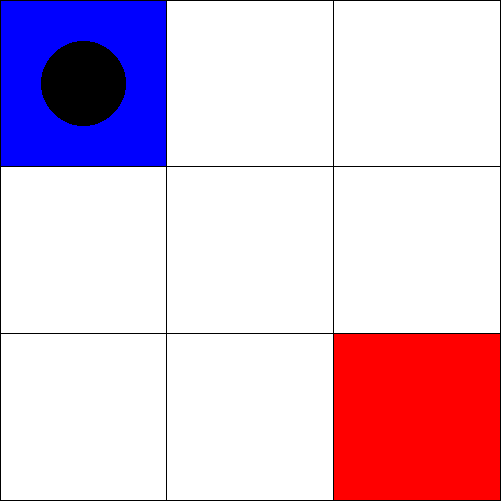

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (0, 1)
Player's new position (0, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  1


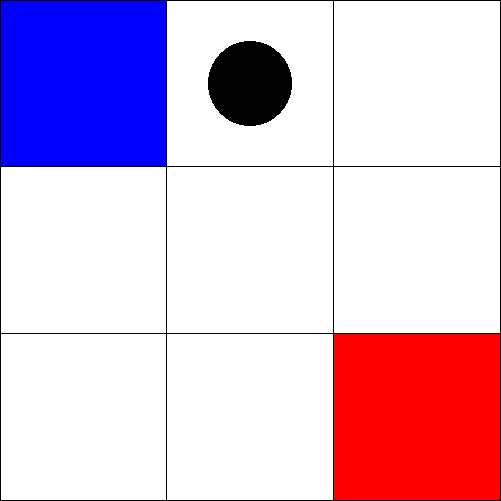

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (0, 0)
Player's new position (0, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  2


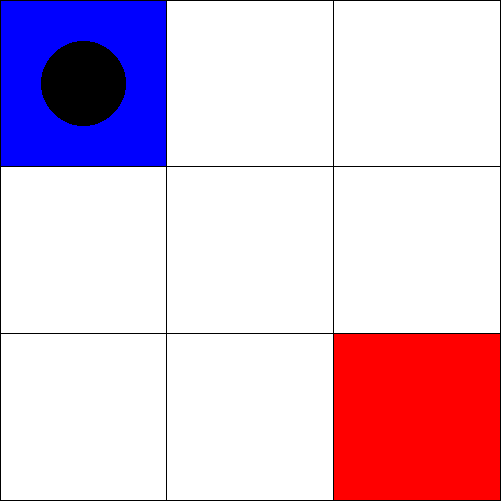

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (-1, 0)
Player's new position (0, 0)
Player's reward for this move -10000
Number of moves made to perform task:  3


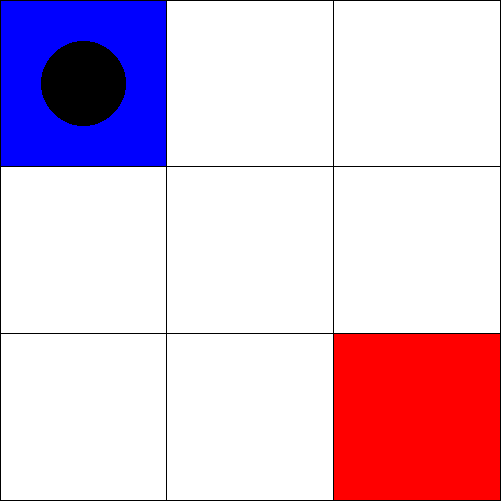

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (0, 1)
Player's new position (0, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  4


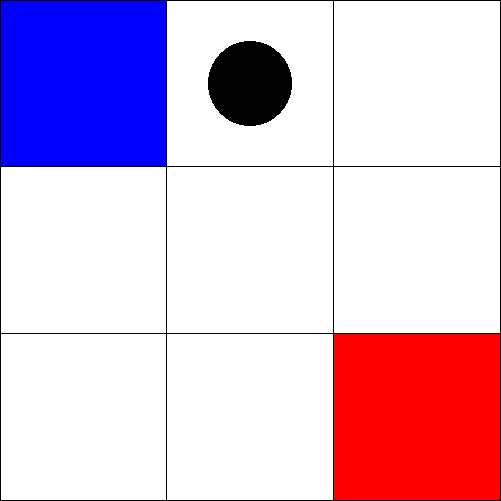

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (-1, 1)
Player's new position (0, 1)
Player's reward for this move -10000
Number of moves made to perform task:  5


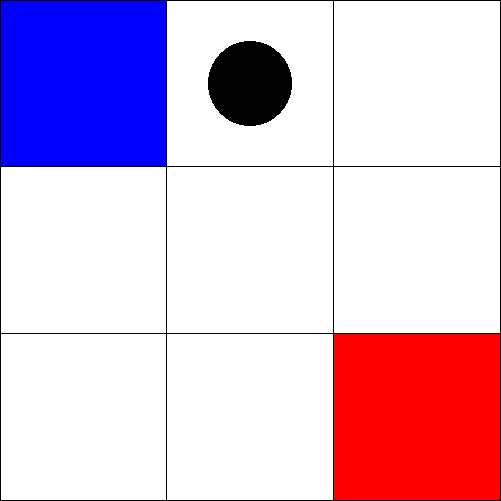

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (1, 1)
Player's new position (1, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  6


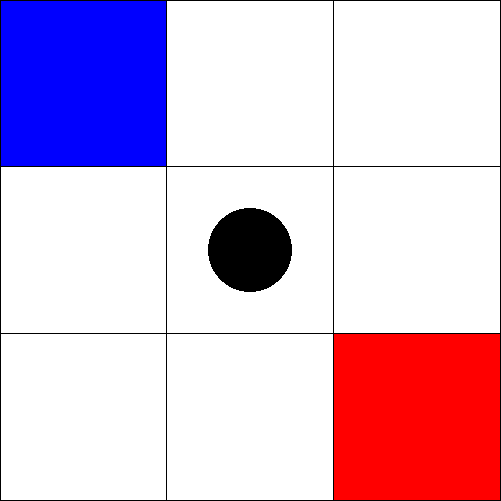

Player's position (1, 1)
Player's possible moves:  [(0, 1), (1, 0), (2, 1), (1, 2)]
Player's chosen move (0, 1)
Player's new position (0, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  7


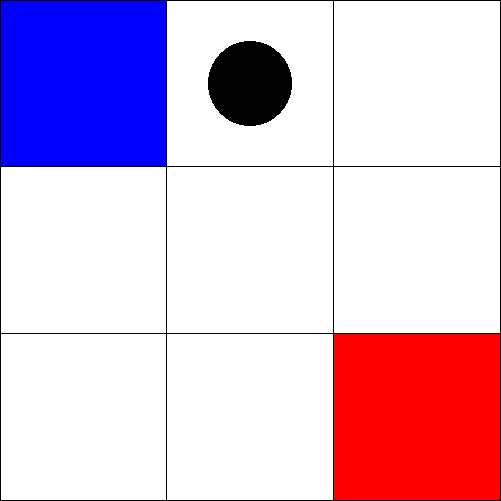

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (1, 1)
Player's new position (1, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  8


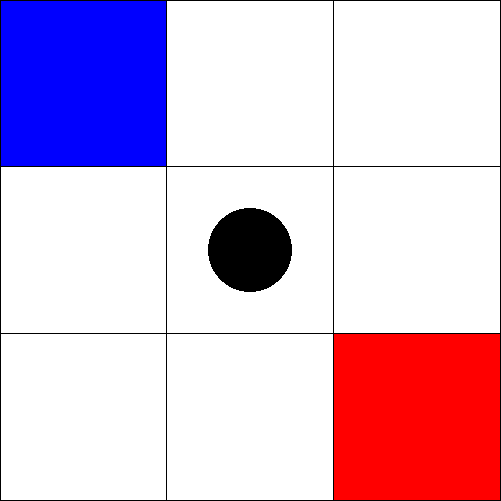

Player's position (1, 1)
Player's possible moves:  [(0, 1), (1, 0), (2, 1), (1, 2)]
Player's chosen move (0, 1)
Player's new position (0, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  9


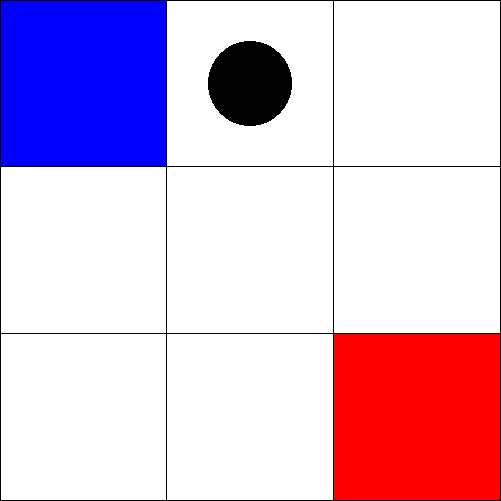

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (1, 1)
Player's new position (1, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  10


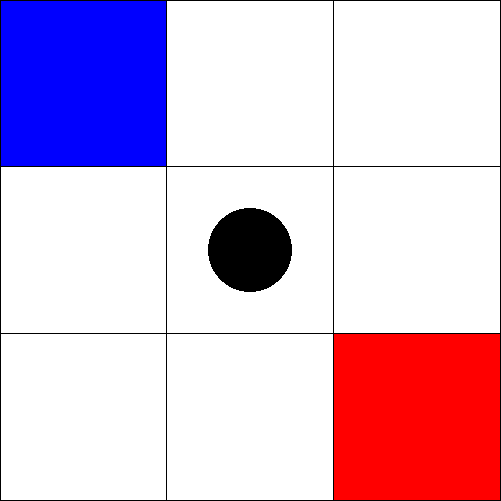

Player's position (1, 1)
Player's possible moves:  [(0, 1), (1, 0), (2, 1), (1, 2)]
Player's chosen move (1, 2)
Player's new position (1, 2)
Player's reward for this move -1.0
Number of moves made to perform task:  11


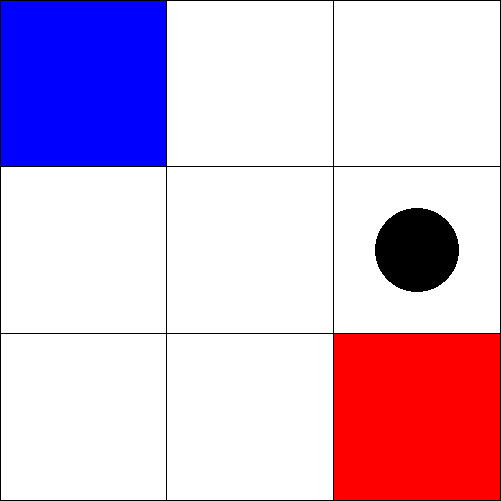

Player's position (1, 2)
Player's possible moves:  [(0, 2), (1, 1), (2, 2), (1, 3)]
Player's chosen move (1, 3)
Player's new position (1, 2)
Player's reward for this move -10000
Number of moves made to perform task:  12


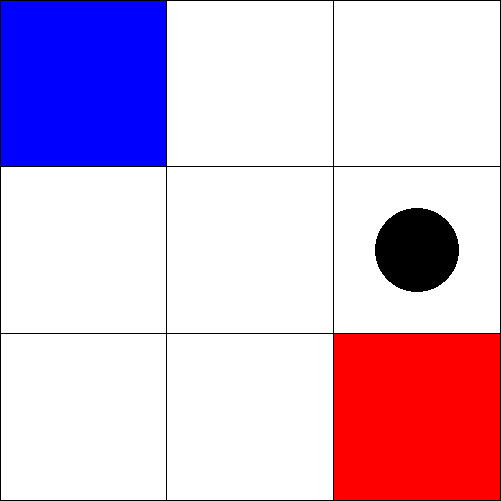

Player's position (1, 2)
Player's possible moves:  [(0, 2), (1, 1), (2, 2), (1, 3)]
Player's chosen move (1, 3)
Player's new position (1, 2)
Player's reward for this move -10000
Number of moves made to perform task:  13


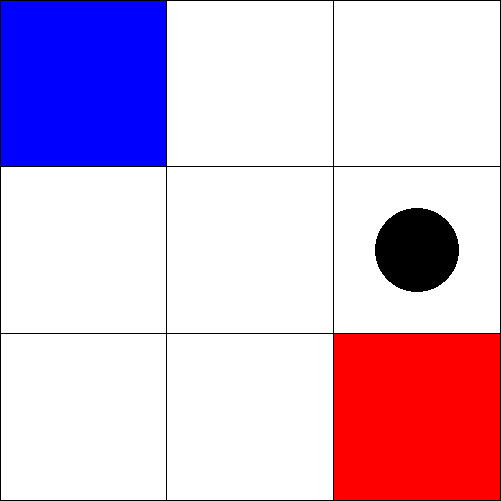

Player's position (1, 2)
Player's possible moves:  [(0, 2), (1, 1), (2, 2), (1, 3)]
Player's chosen move (1, 1)
Player's new position (1, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  14


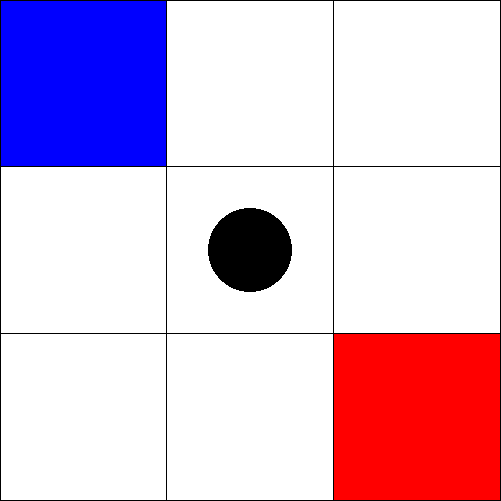

Player's position (1, 1)
Player's possible moves:  [(0, 1), (1, 0), (2, 1), (1, 2)]
Player's chosen move (2, 1)
Player's new position (2, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  15


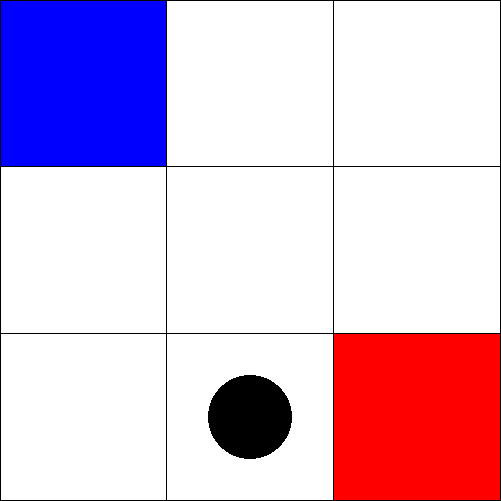

Player's position (2, 1)
Player's possible moves:  [(1, 1), (2, 0), (3, 1), (2, 2)]
Player's chosen move (3, 1)
Player's new position (2, 1)
Player's reward for this move -10000
Number of moves made to perform task:  16


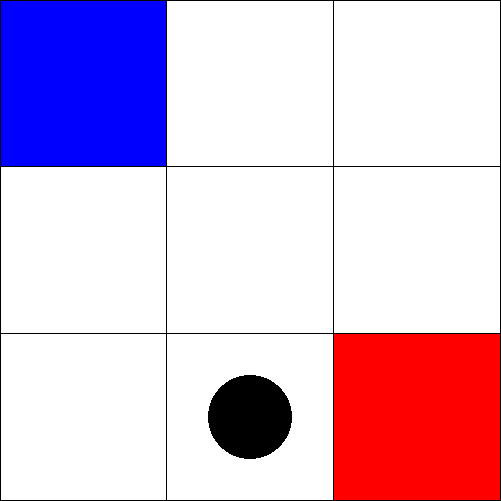

Player's position (2, 1)
Player's possible moves:  [(1, 1), (2, 0), (3, 1), (2, 2)]
Player's chosen move (2, 2)
Player's new position (2, 2)
Player's reward for this move 0.0
Number of moves made to perform task:  17


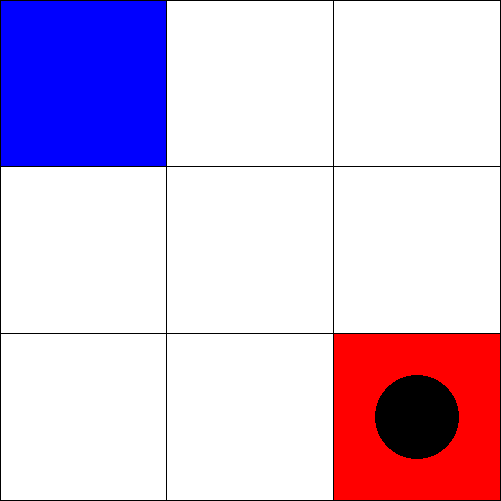

Player finished task in : 17  moves
Player scores for every episode:  [-50011.0]


In [25]:
reward_matrix = np.ones((3,3))*-1
reward_matrix[(2,2)] = 0
print(reward_matrix)
target_game = Targeting_Game( (3,3), (0,0), (2,2), reward_matrix)
play_game(target_game, 1, output=True)

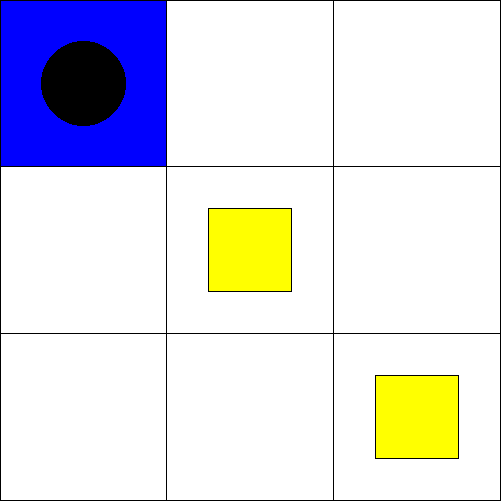

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (1, 0)
Player's new position (1, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  1


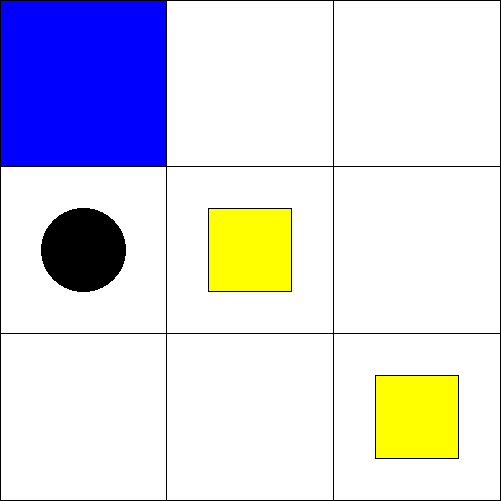

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (0, 0)
Player's new position (0, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  2


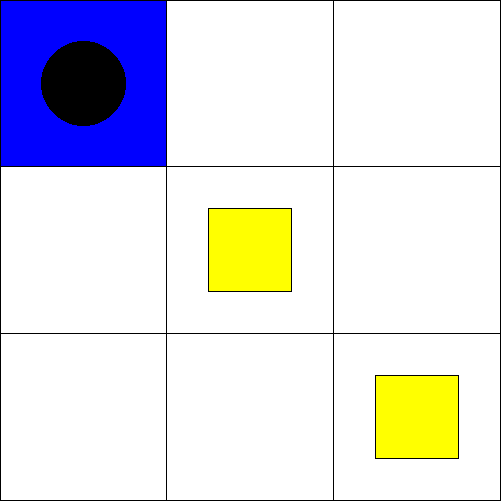

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (1, 0)
Player's new position (1, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  3


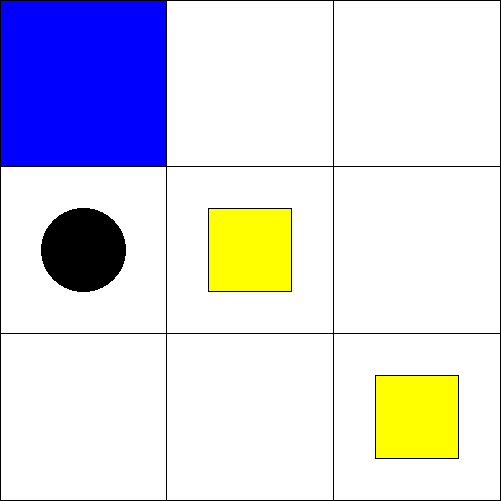

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (2, 0)
Player's new position (2, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  4


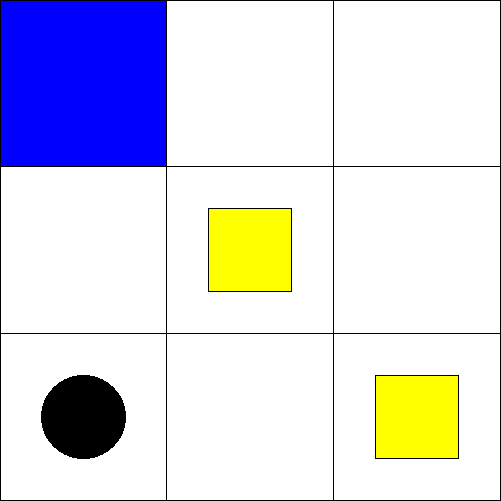

Player's position (2, 0)
Player's possible moves:  [(1, 0), (2, -1), (3, 0), (2, 1)]
Player's chosen move (3, 0)
Player's new position (2, 0)
Player's reward for this move -10000
Number of moves made to perform task:  5


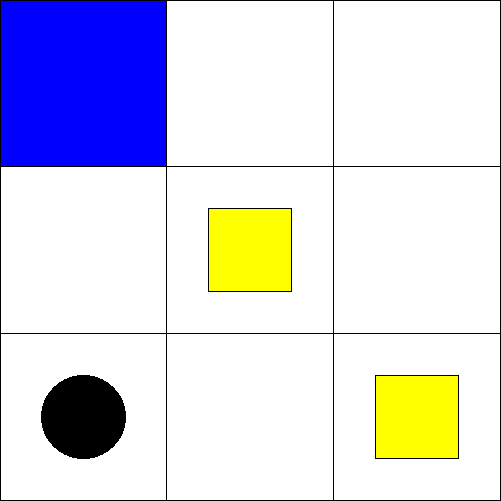

Player's position (2, 0)
Player's possible moves:  [(1, 0), (2, -1), (3, 0), (2, 1)]
Player's chosen move (2, 1)
Player's new position (2, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  6


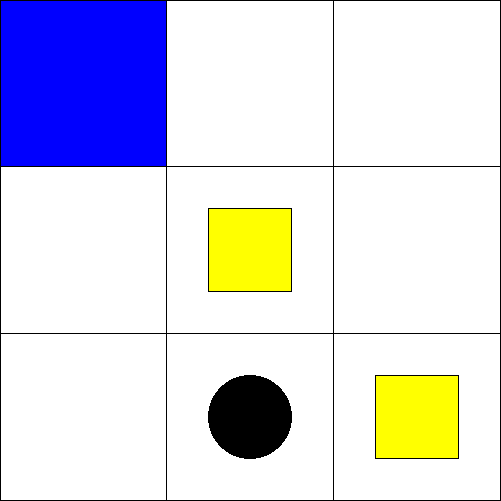

Player's position (2, 1)
Player's possible moves:  [(1, 1), (2, 0), (3, 1), (2, 2)]
Player's chosen move (2, 0)
Player's new position (2, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  7


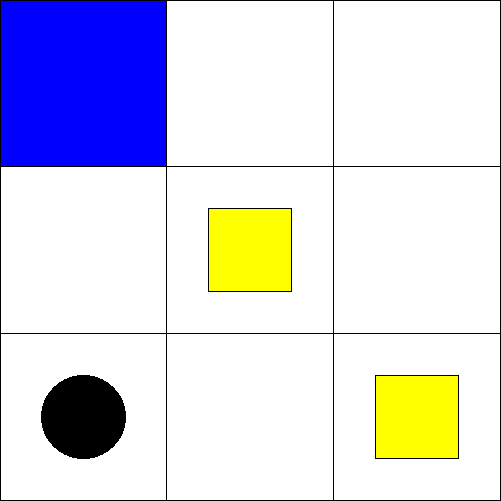

Player's position (2, 0)
Player's possible moves:  [(1, 0), (2, -1), (3, 0), (2, 1)]
Player's chosen move (3, 0)
Player's new position (2, 0)
Player's reward for this move -10000
Number of moves made to perform task:  8


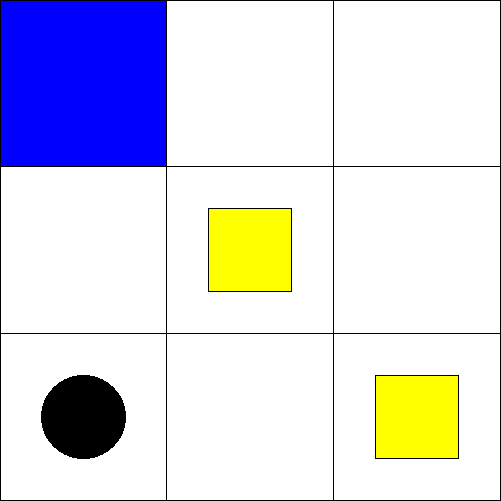

Player's position (2, 0)
Player's possible moves:  [(1, 0), (2, -1), (3, 0), (2, 1)]
Player's chosen move (1, 0)
Player's new position (1, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  9


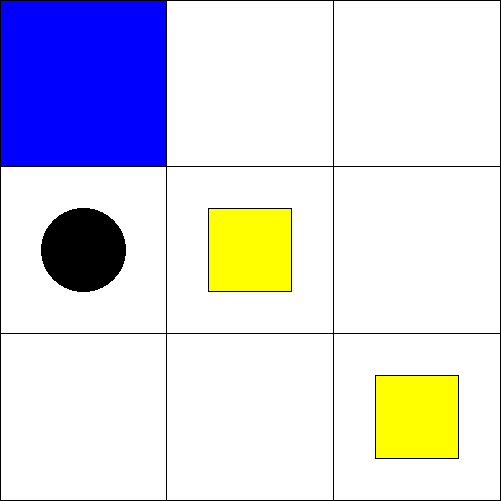

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (0, 0)
Player's new position (0, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  10


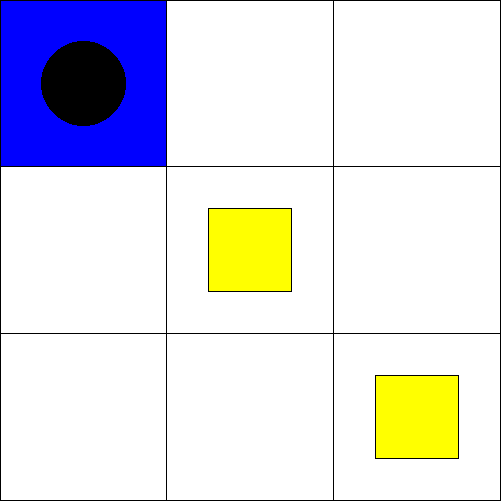

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (1, 0)
Player's new position (1, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  11


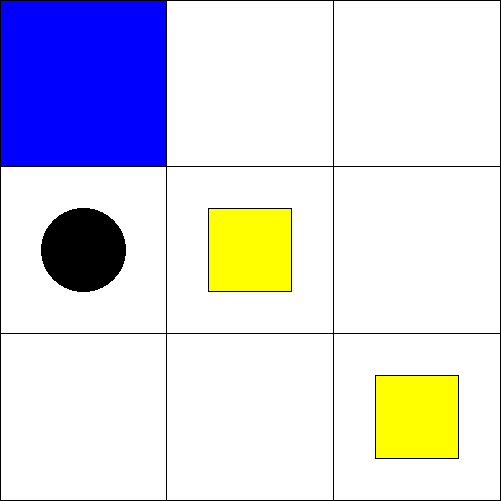

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (0, 0)
Player's new position (0, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  12


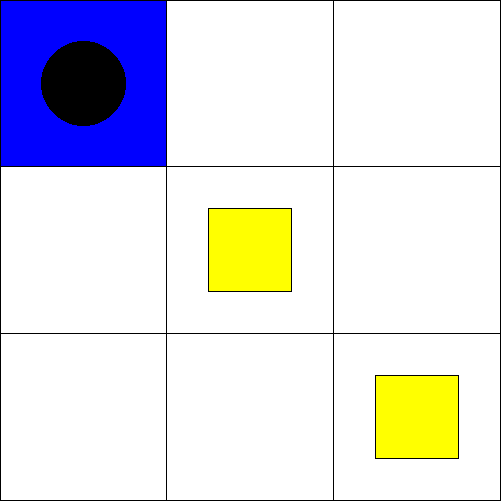

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (-1, 0)
Player's new position (0, 0)
Player's reward for this move -10000
Number of moves made to perform task:  13


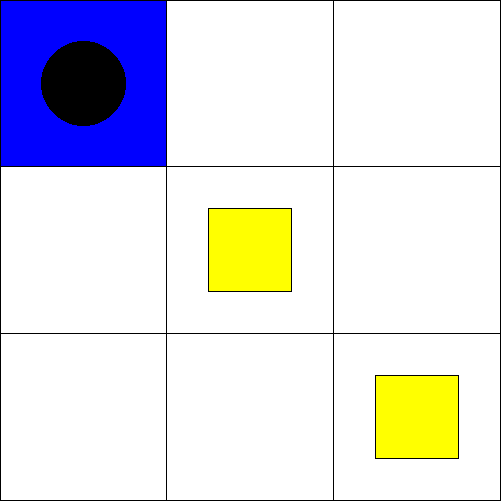

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (0, 1)
Player's new position (0, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  14


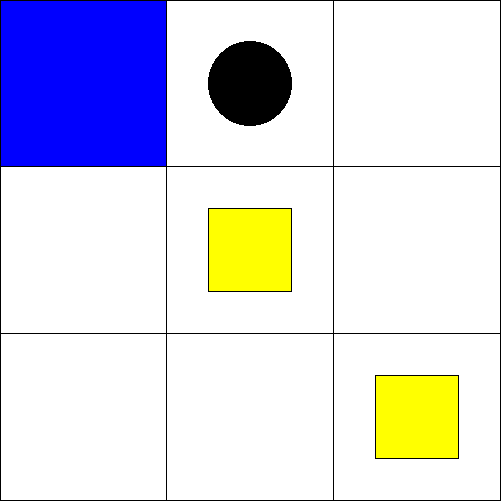

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (-1, 1)
Player's new position (0, 1)
Player's reward for this move -10000
Number of moves made to perform task:  15


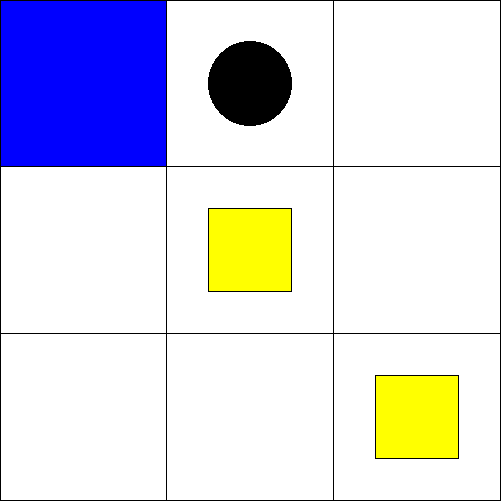

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (0, 2)
Player's new position (0, 2)
Player's reward for this move -1.0
Number of moves made to perform task:  16


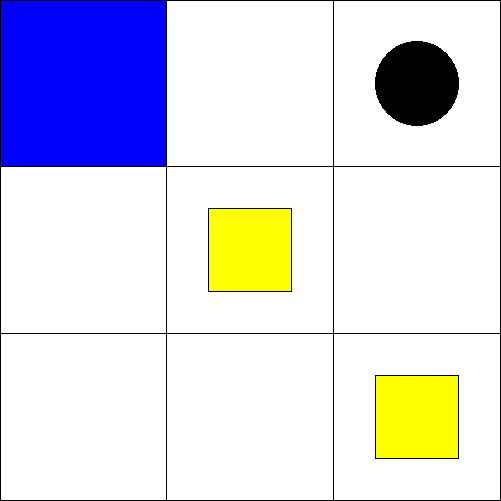

Player's position (0, 2)
Player's possible moves:  [(-1, 2), (0, 1), (1, 2), (0, 3)]
Player's chosen move (0, 3)
Player's new position (0, 2)
Player's reward for this move -10000
Number of moves made to perform task:  17


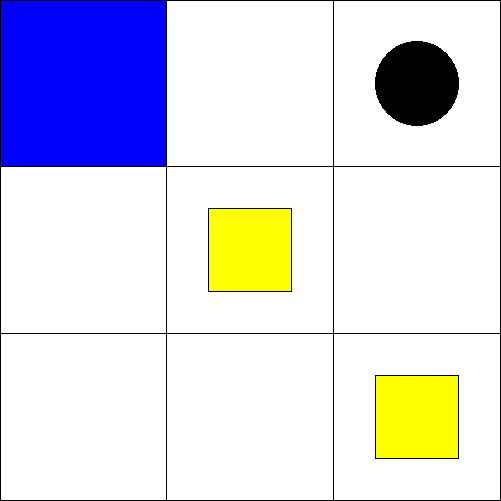

Player's position (0, 2)
Player's possible moves:  [(-1, 2), (0, 1), (1, 2), (0, 3)]
Player's chosen move (0, 3)
Player's new position (0, 2)
Player's reward for this move -10000
Number of moves made to perform task:  18


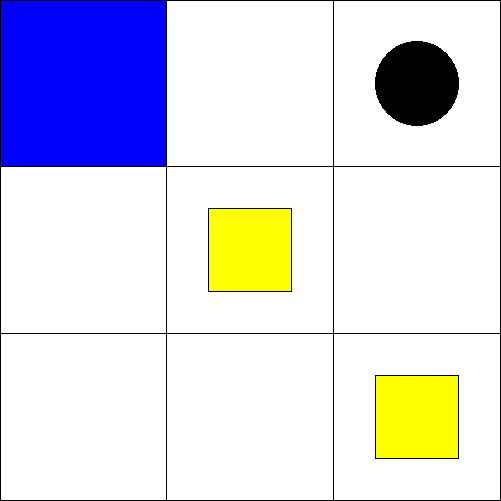

Player's position (0, 2)
Player's possible moves:  [(-1, 2), (0, 1), (1, 2), (0, 3)]
Player's chosen move (0, 3)
Player's new position (0, 2)
Player's reward for this move -10000
Number of moves made to perform task:  19


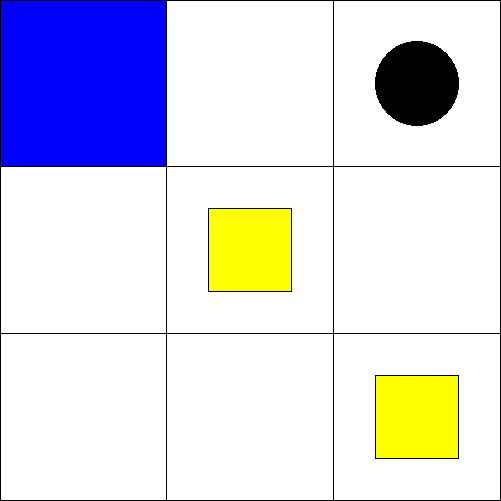

Player's position (0, 2)
Player's possible moves:  [(-1, 2), (0, 1), (1, 2), (0, 3)]
Player's chosen move (0, 1)
Player's new position (0, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  20


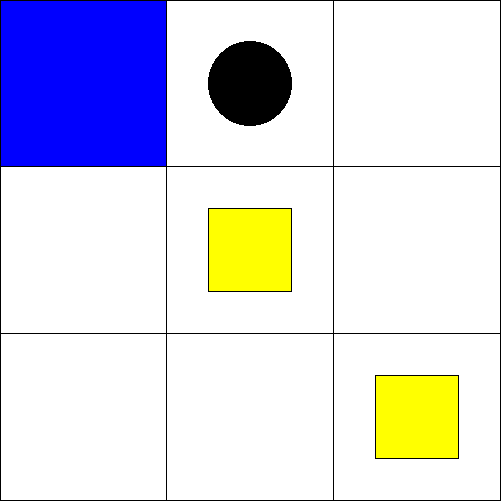

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (-1, 1)
Player's new position (0, 1)
Player's reward for this move -10000
Number of moves made to perform task:  21


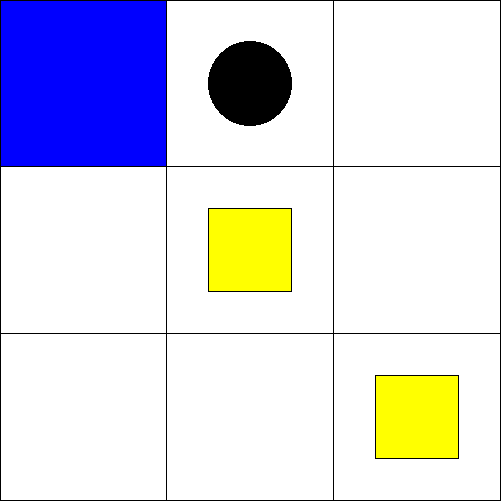

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (0, 0)
Player's new position (0, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  22


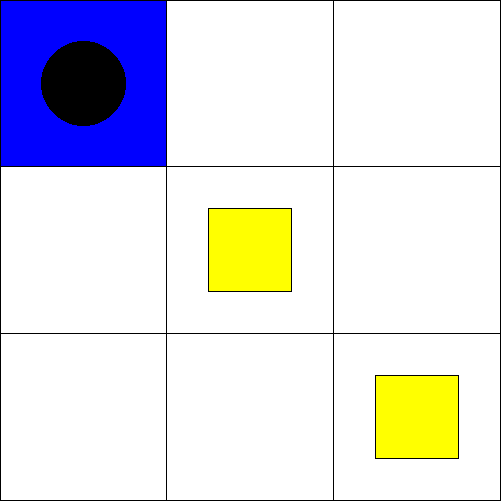

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (-1, 0)
Player's new position (0, 0)
Player's reward for this move -10000
Number of moves made to perform task:  23


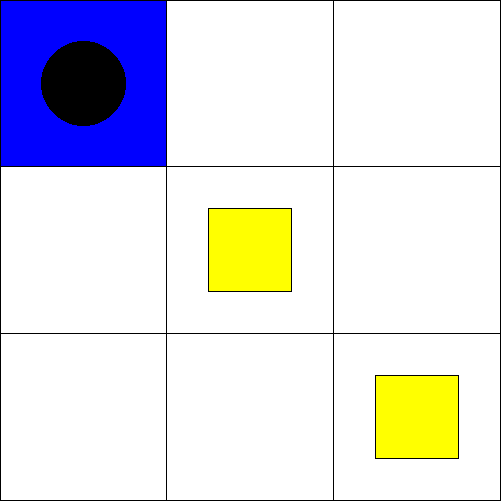

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (0, 1)
Player's new position (0, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  24


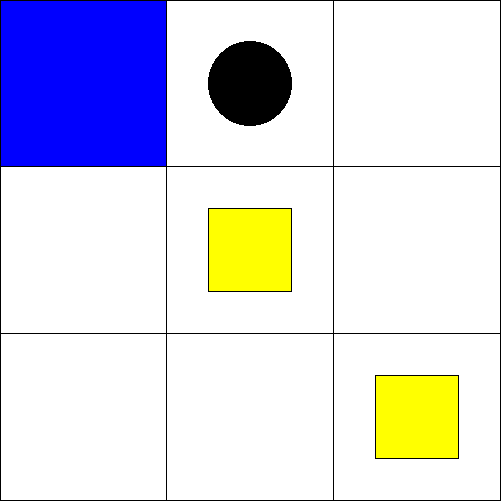

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (1, 1)
Player's new position (1, 1)
Player's reward for this move 0.0
Number of moves made to perform task:  25


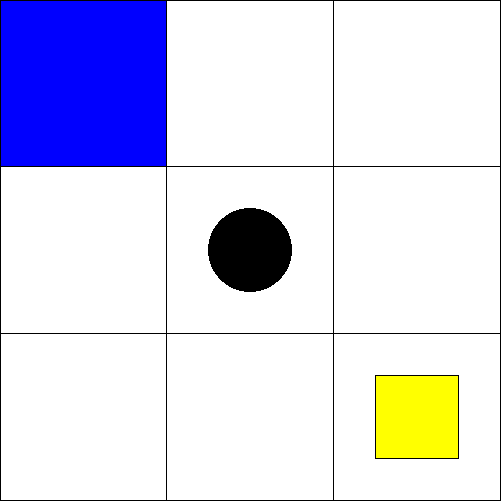

Player's position (1, 1)
Player's possible moves:  [(0, 1), (1, 0), (2, 1), (1, 2)]
Player's chosen move (0, 1)
Player's new position (0, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  26


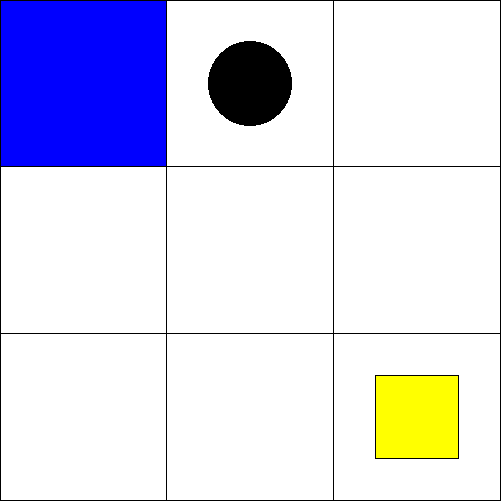

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (-1, 1)
Player's new position (0, 1)
Player's reward for this move -10000
Number of moves made to perform task:  27


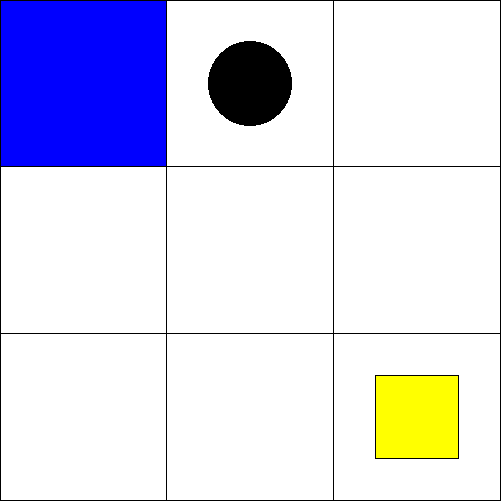

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (-1, 1)
Player's new position (0, 1)
Player's reward for this move -10000
Number of moves made to perform task:  28


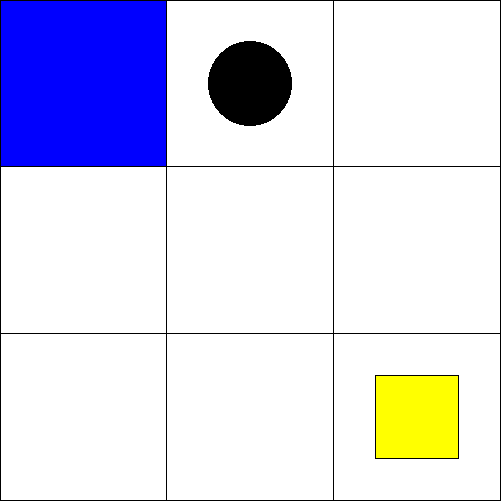

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (0, 0)
Player's new position (0, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  29


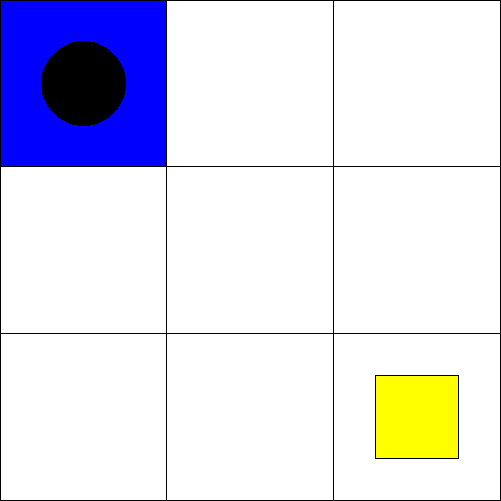

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (-1, 0)
Player's new position (0, 0)
Player's reward for this move -10000
Number of moves made to perform task:  30


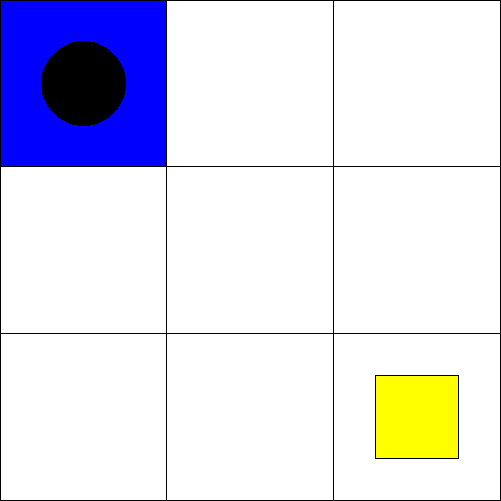

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (-1, 0)
Player's new position (0, 0)
Player's reward for this move -10000
Number of moves made to perform task:  31


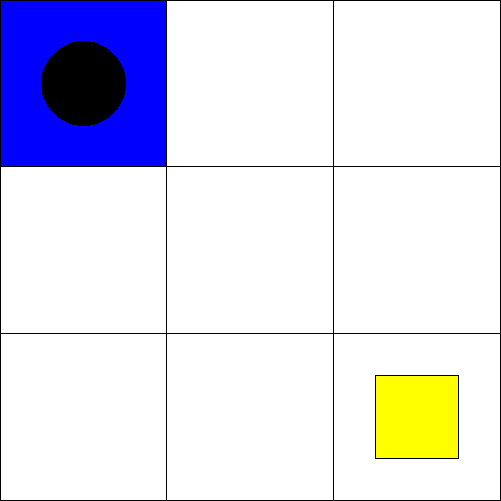

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (0, -1)
Player's new position (0, 0)
Player's reward for this move -10000
Number of moves made to perform task:  32


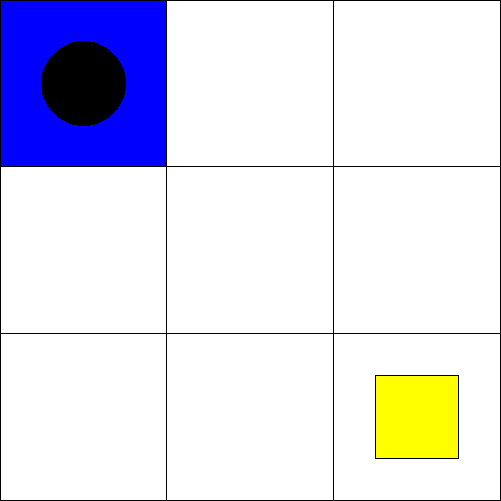

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (0, 1)
Player's new position (0, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  33


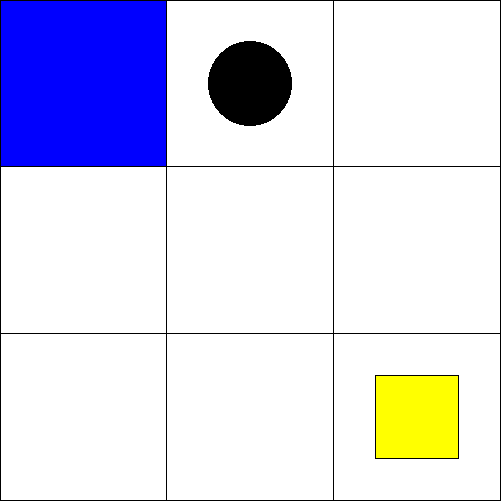

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (-1, 1)
Player's new position (0, 1)
Player's reward for this move -10000
Number of moves made to perform task:  34


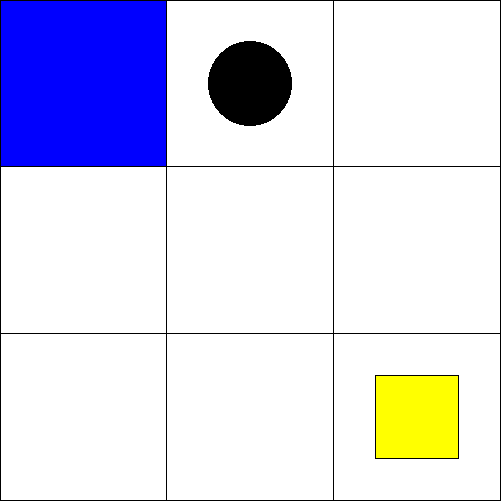

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (1, 1)
Player's new position (1, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  35


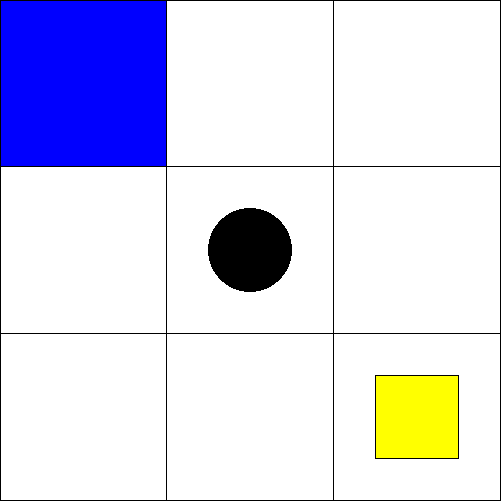

Player's position (1, 1)
Player's possible moves:  [(0, 1), (1, 0), (2, 1), (1, 2)]
Player's chosen move (2, 1)
Player's new position (2, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  36


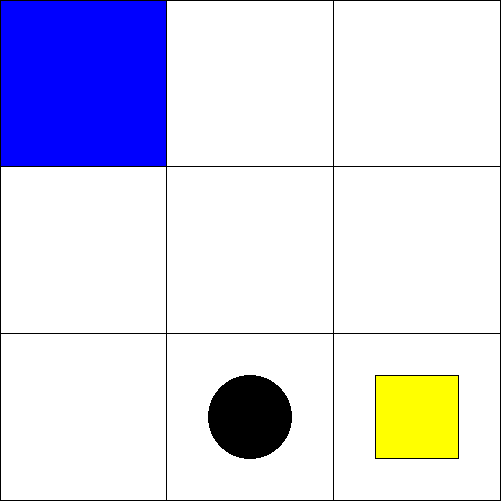

Player's position (2, 1)
Player's possible moves:  [(1, 1), (2, 0), (3, 1), (2, 2)]
Player's chosen move (3, 1)
Player's new position (2, 1)
Player's reward for this move -10000
Number of moves made to perform task:  37


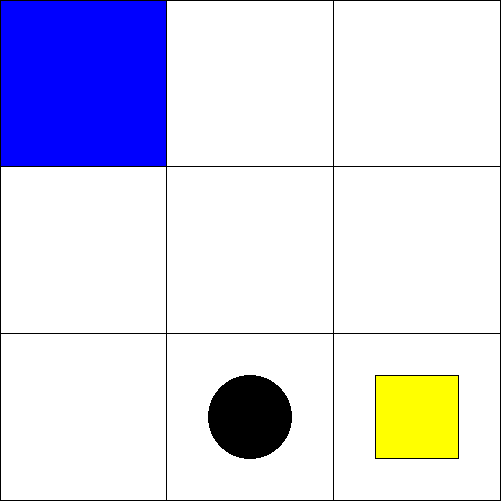

Player's position (2, 1)
Player's possible moves:  [(1, 1), (2, 0), (3, 1), (2, 2)]
Player's chosen move (2, 2)
Player's new position (2, 2)
Player's reward for this move 0.0
Number of moves made to perform task:  38


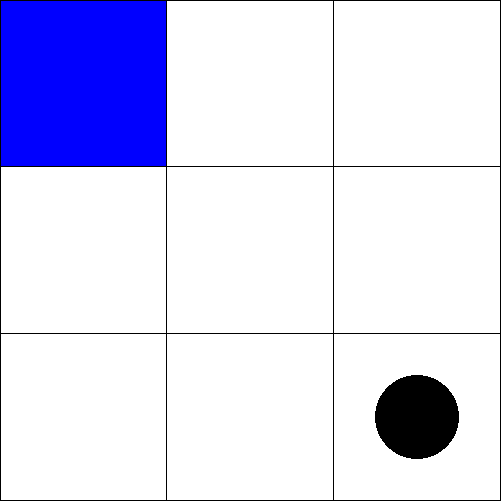

Player finished task in : 38  moves


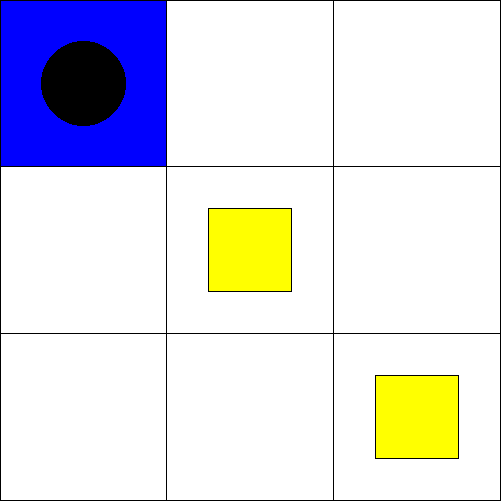

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (1, 0)
Player's new position (1, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  1


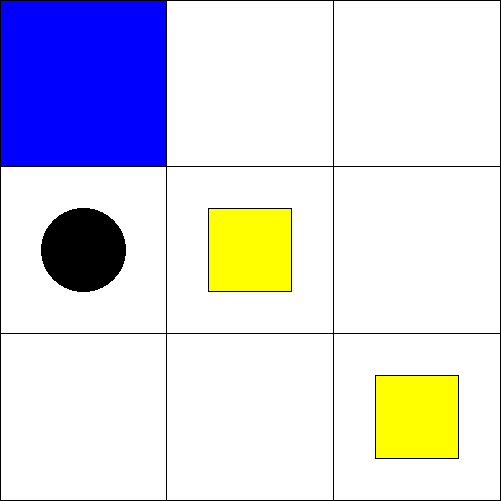

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (0, 0)
Player's new position (0, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  2


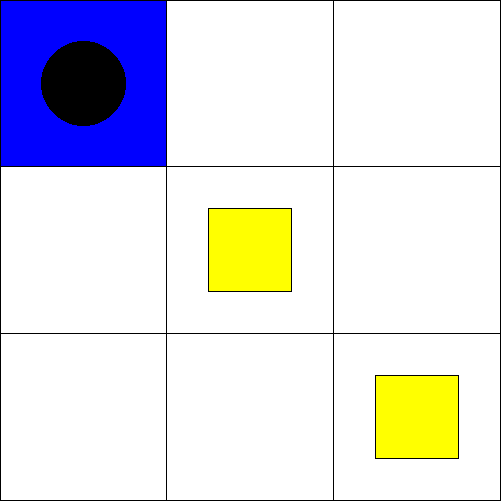

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (0, -1)
Player's new position (0, 0)
Player's reward for this move -10000
Number of moves made to perform task:  3


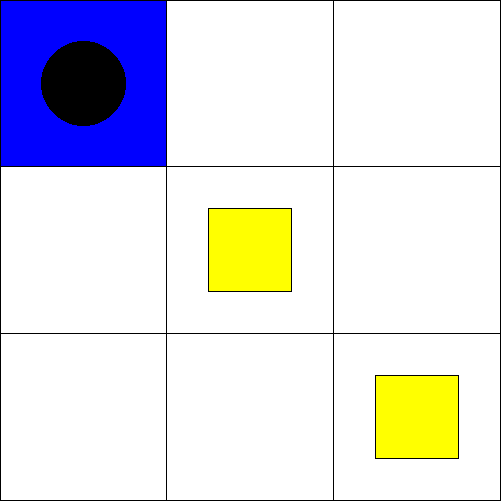

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (1, 0)
Player's new position (1, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  4


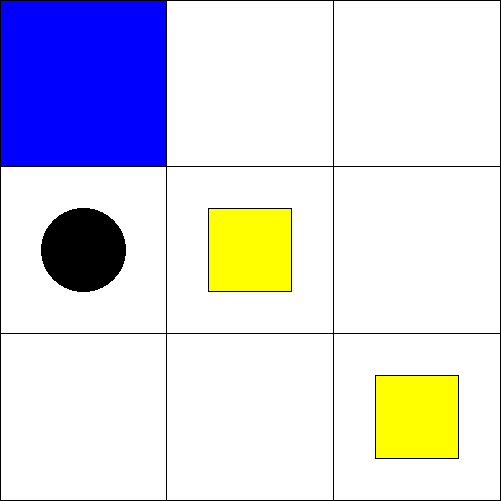

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (1, -1)
Player's new position (1, 0)
Player's reward for this move -10000
Number of moves made to perform task:  5


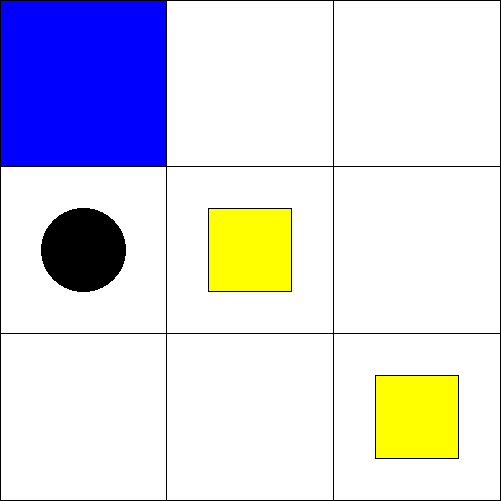

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (0, 0)
Player's new position (0, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  6


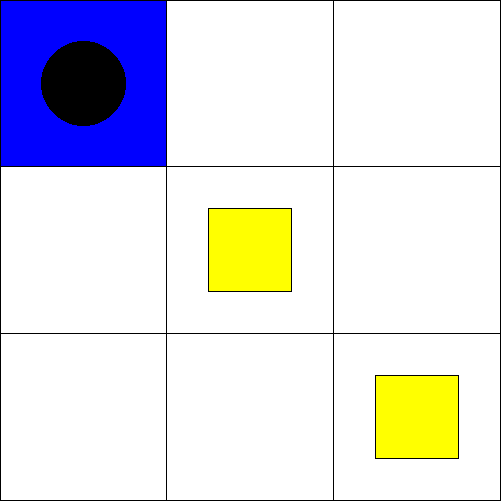

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (1, 0)
Player's new position (1, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  7


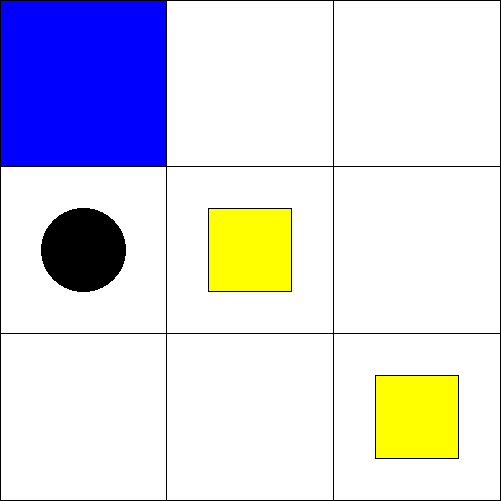

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (1, -1)
Player's new position (1, 0)
Player's reward for this move -10000
Number of moves made to perform task:  8


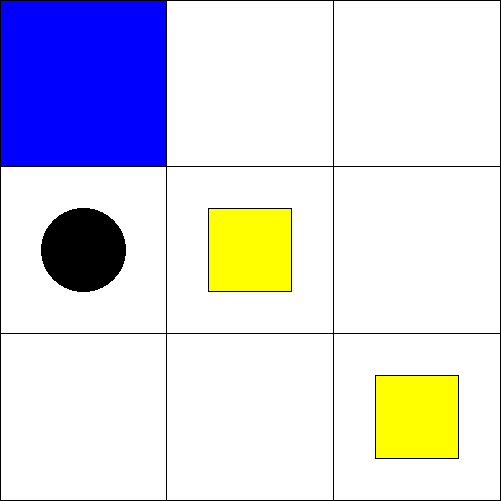

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (1, 1)
Player's new position (1, 1)
Player's reward for this move 0.0
Number of moves made to perform task:  9


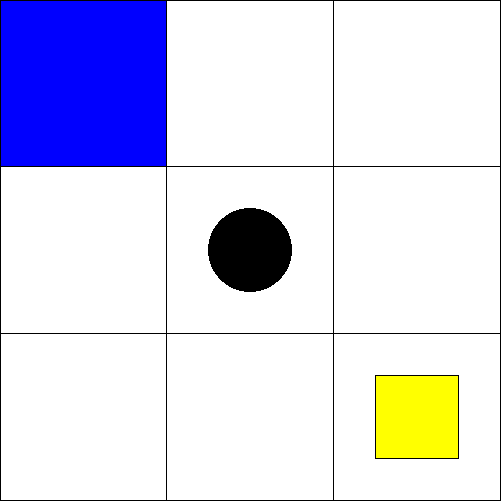

Player's position (1, 1)
Player's possible moves:  [(0, 1), (1, 0), (2, 1), (1, 2)]
Player's chosen move (1, 0)
Player's new position (1, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  10


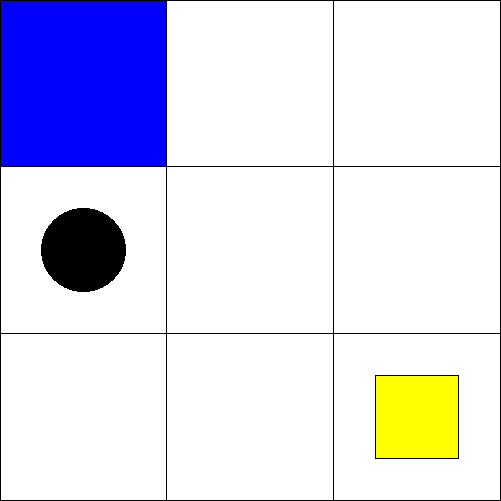

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (1, -1)
Player's new position (1, 0)
Player's reward for this move -10000
Number of moves made to perform task:  11


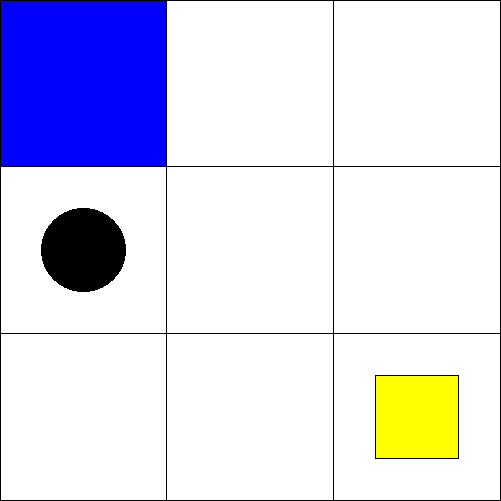

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (1, -1)
Player's new position (1, 0)
Player's reward for this move -10000
Number of moves made to perform task:  12


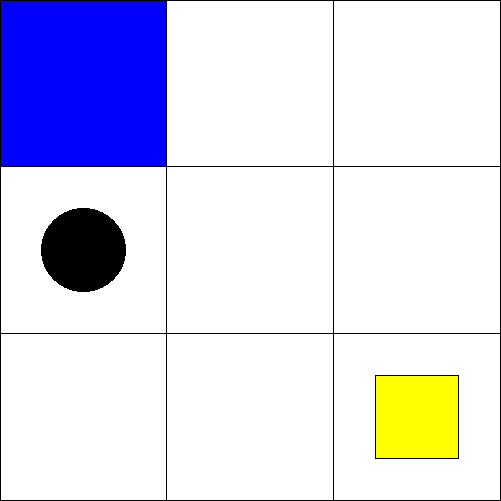

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (1, -1)
Player's new position (1, 0)
Player's reward for this move -10000
Number of moves made to perform task:  13


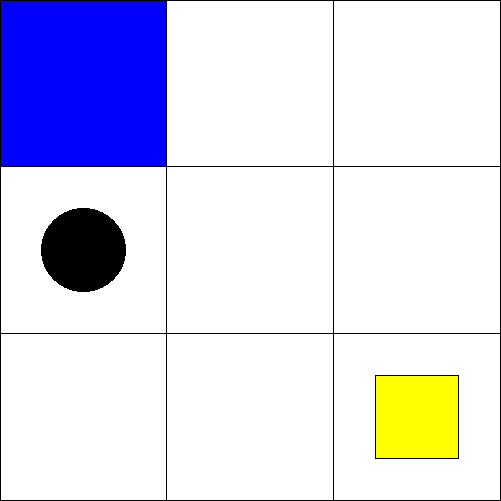

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (0, 0)
Player's new position (0, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  14


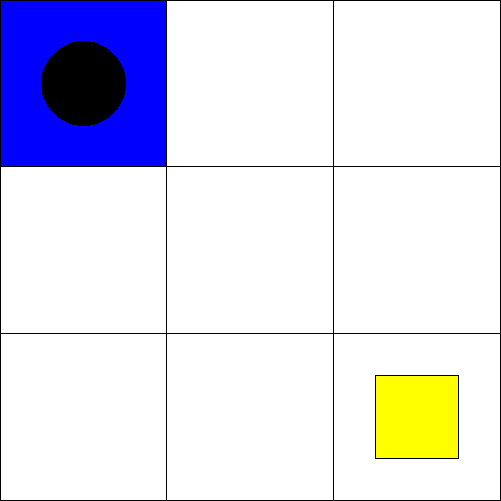

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (1, 0)
Player's new position (1, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  15


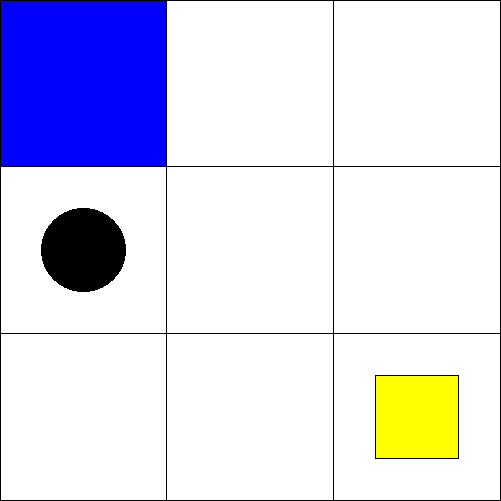

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (1, -1)
Player's new position (1, 0)
Player's reward for this move -10000
Number of moves made to perform task:  16


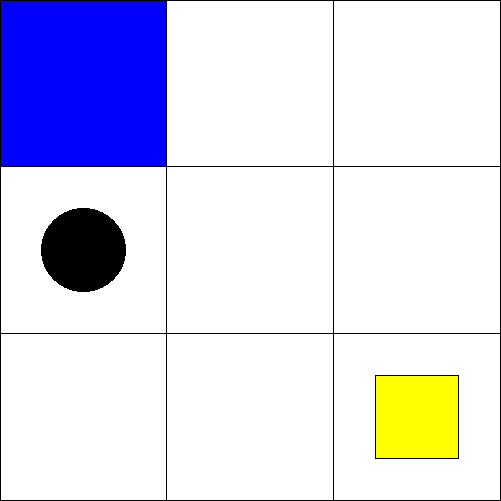

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (1, -1)
Player's new position (1, 0)
Player's reward for this move -10000
Number of moves made to perform task:  17


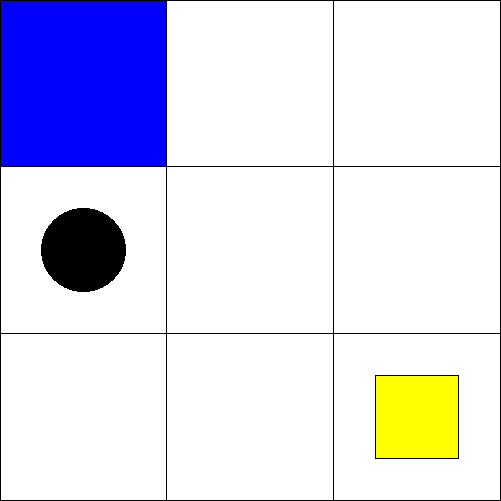

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (1, 1)
Player's new position (1, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  18


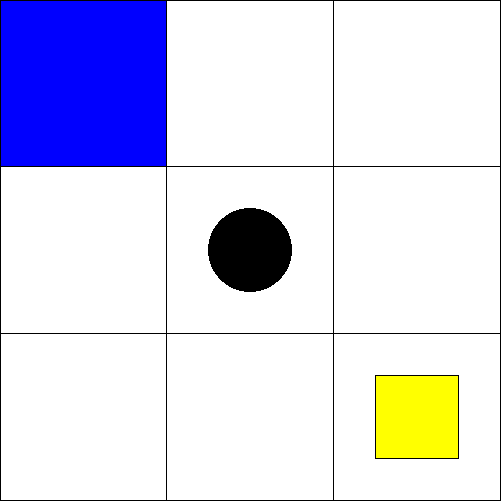

Player's position (1, 1)
Player's possible moves:  [(0, 1), (1, 0), (2, 1), (1, 2)]
Player's chosen move (1, 0)
Player's new position (1, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  19


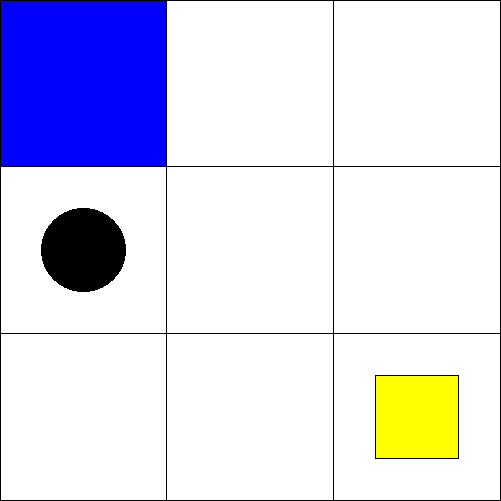

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (1, -1)
Player's new position (1, 0)
Player's reward for this move -10000
Number of moves made to perform task:  20


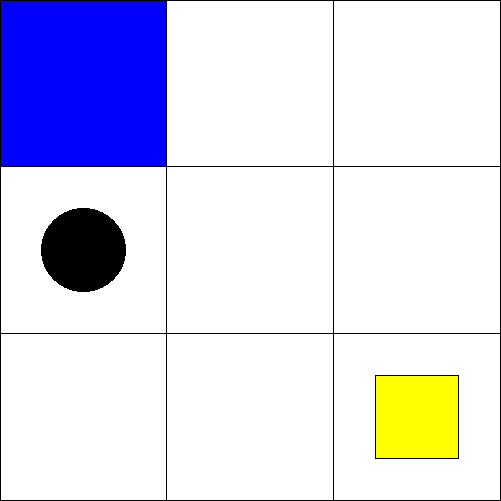

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (0, 0)
Player's new position (0, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  21


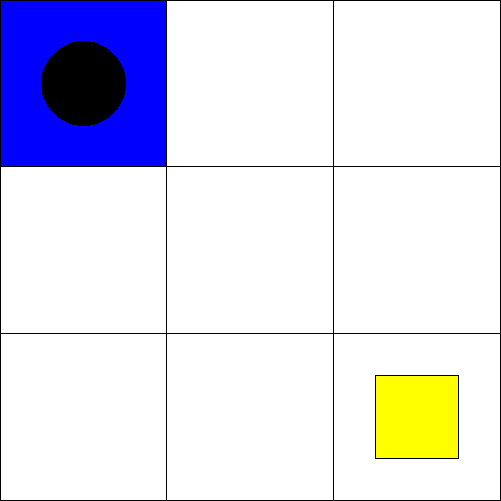

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (0, -1)
Player's new position (0, 0)
Player's reward for this move -10000
Number of moves made to perform task:  22


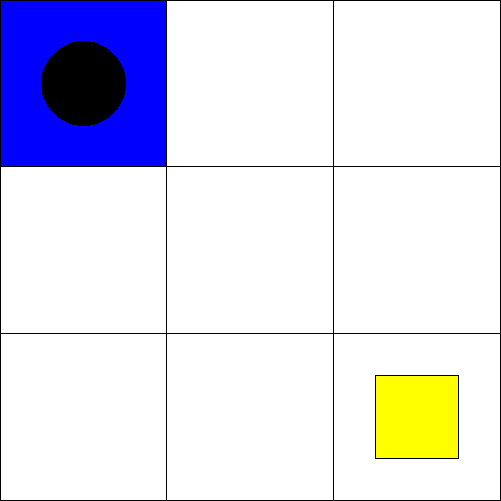

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (1, 0)
Player's new position (1, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  23


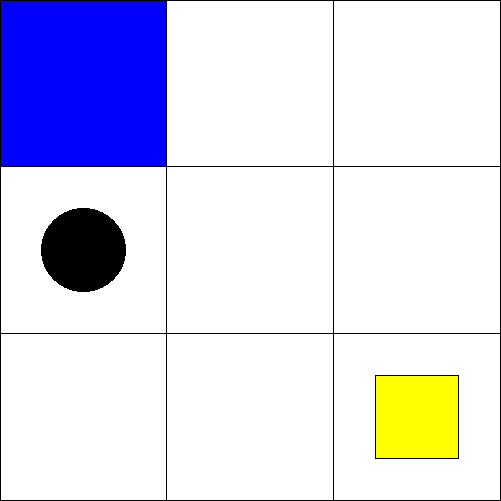

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (1, -1)
Player's new position (1, 0)
Player's reward for this move -10000
Number of moves made to perform task:  24


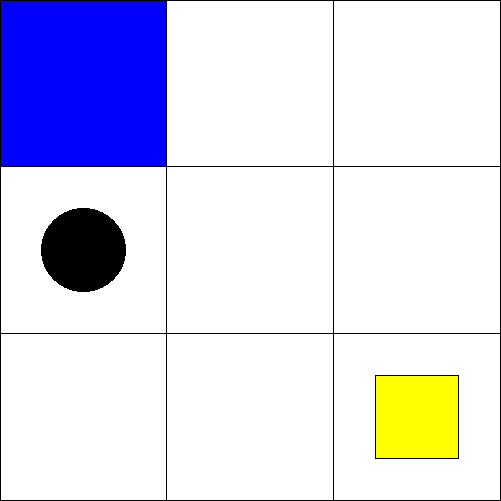

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (2, 0)
Player's new position (2, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  25


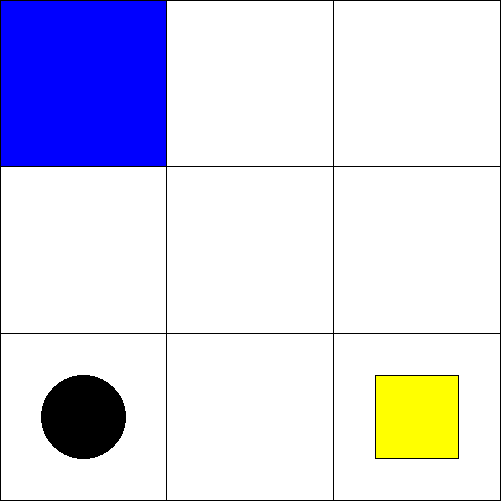

Player's position (2, 0)
Player's possible moves:  [(1, 0), (2, -1), (3, 0), (2, 1)]
Player's chosen move (2, -1)
Player's new position (2, 0)
Player's reward for this move -10000
Number of moves made to perform task:  26


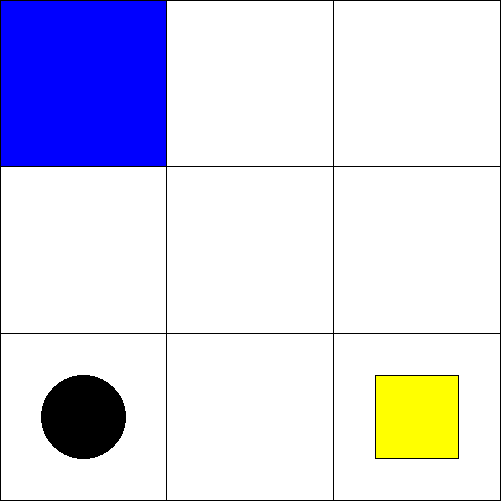

Player's position (2, 0)
Player's possible moves:  [(1, 0), (2, -1), (3, 0), (2, 1)]
Player's chosen move (3, 0)
Player's new position (2, 0)
Player's reward for this move -10000
Number of moves made to perform task:  27


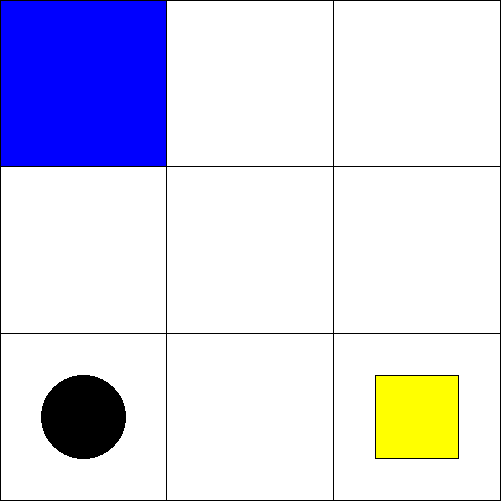

Player's position (2, 0)
Player's possible moves:  [(1, 0), (2, -1), (3, 0), (2, 1)]
Player's chosen move (3, 0)
Player's new position (2, 0)
Player's reward for this move -10000
Number of moves made to perform task:  28


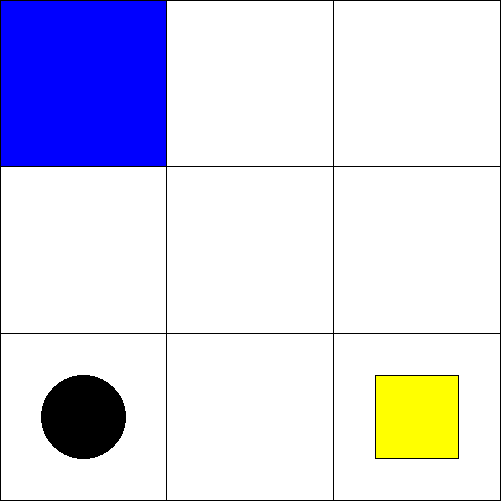

Player's position (2, 0)
Player's possible moves:  [(1, 0), (2, -1), (3, 0), (2, 1)]
Player's chosen move (2, -1)
Player's new position (2, 0)
Player's reward for this move -10000
Number of moves made to perform task:  29


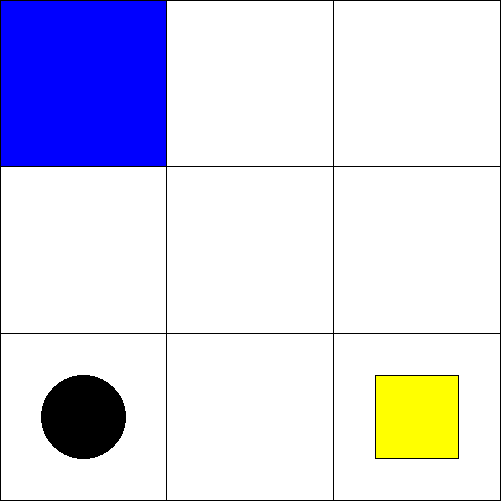

Player's position (2, 0)
Player's possible moves:  [(1, 0), (2, -1), (3, 0), (2, 1)]
Player's chosen move (1, 0)
Player's new position (1, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  30


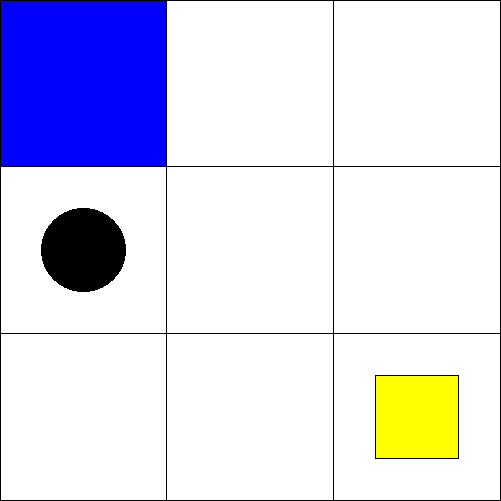

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (1, -1)
Player's new position (1, 0)
Player's reward for this move -10000
Number of moves made to perform task:  31


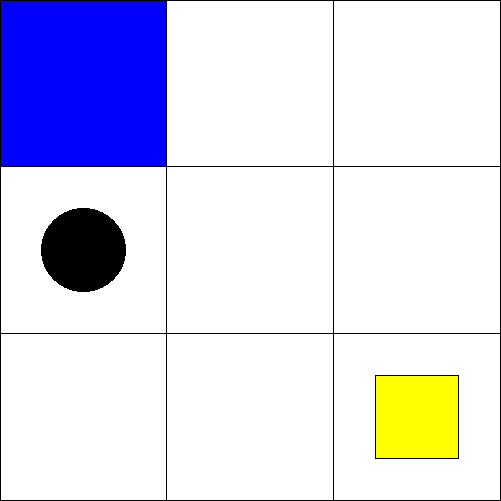

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (0, 0)
Player's new position (0, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  32


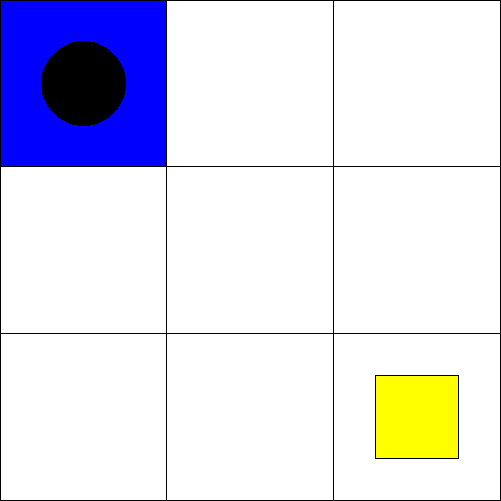

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (1, 0)
Player's new position (1, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  33


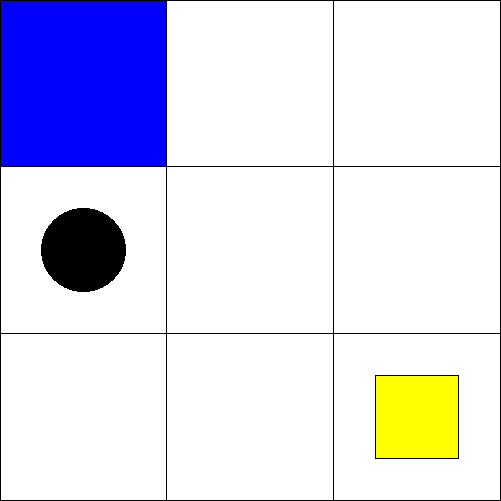

Player's position (1, 0)
Player's possible moves:  [(0, 0), (1, -1), (2, 0), (1, 1)]
Player's chosen move (0, 0)
Player's new position (0, 0)
Player's reward for this move -1.0
Number of moves made to perform task:  34


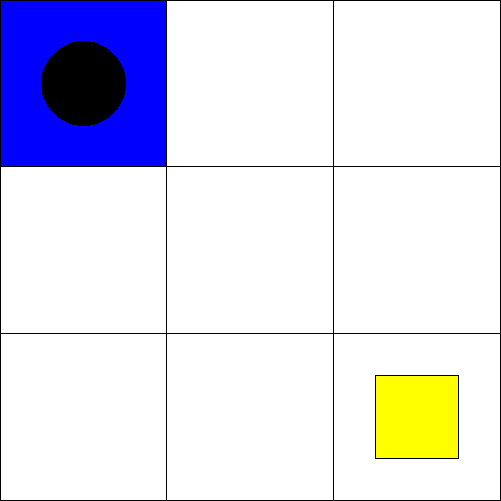

Player's position (0, 0)
Player's possible moves:  [(-1, 0), (0, -1), (1, 0), (0, 1)]
Player's chosen move (0, 1)
Player's new position (0, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  35


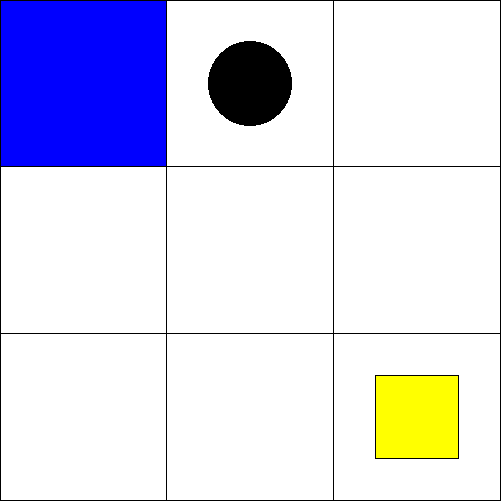

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (1, 1)
Player's new position (1, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  36


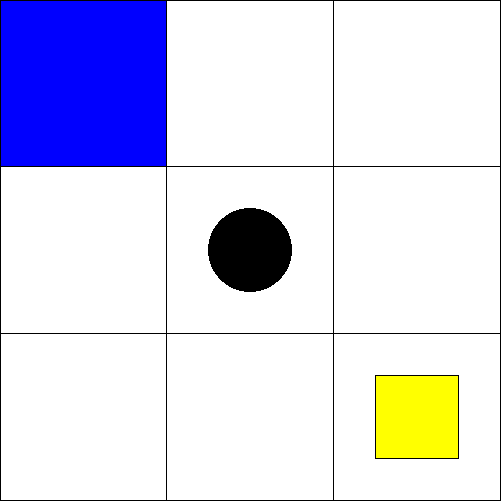

Player's position (1, 1)
Player's possible moves:  [(0, 1), (1, 0), (2, 1), (1, 2)]
Player's chosen move (0, 1)
Player's new position (0, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  37


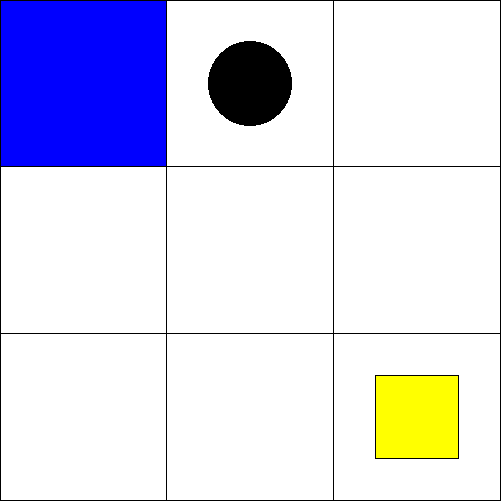

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (1, 1)
Player's new position (1, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  38


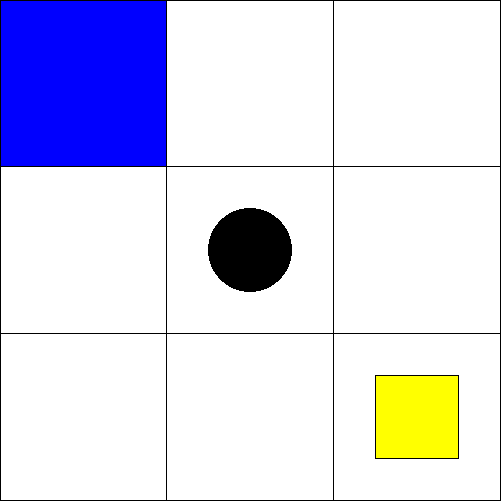

Player's position (1, 1)
Player's possible moves:  [(0, 1), (1, 0), (2, 1), (1, 2)]
Player's chosen move (0, 1)
Player's new position (0, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  39


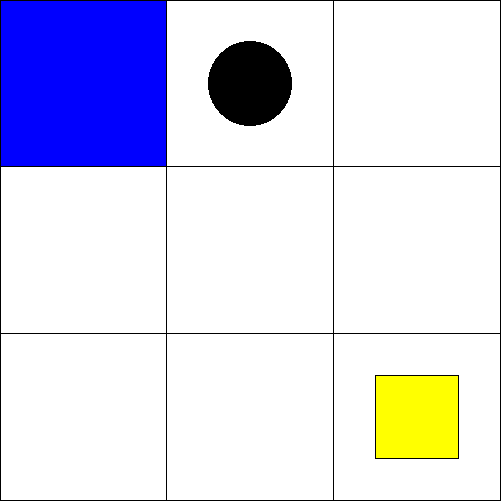

Player's position (0, 1)
Player's possible moves:  [(-1, 1), (0, 0), (1, 1), (0, 2)]
Player's chosen move (1, 1)
Player's new position (1, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  40


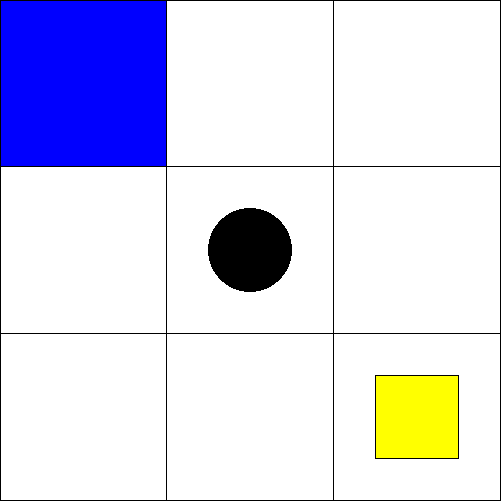

Player's position (1, 1)
Player's possible moves:  [(0, 1), (1, 0), (2, 1), (1, 2)]
Player's chosen move (2, 1)
Player's new position (2, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  41


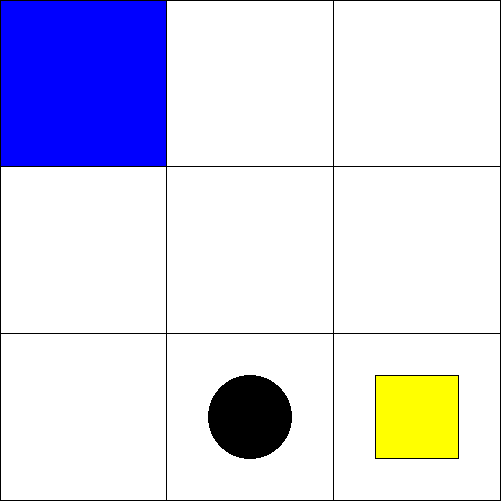

Player's position (2, 1)
Player's possible moves:  [(1, 1), (2, 0), (3, 1), (2, 2)]
Player's chosen move (1, 1)
Player's new position (1, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  42


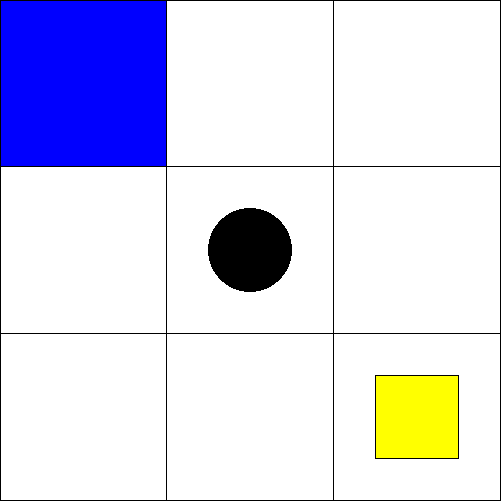

Player's position (1, 1)
Player's possible moves:  [(0, 1), (1, 0), (2, 1), (1, 2)]
Player's chosen move (1, 2)
Player's new position (1, 2)
Player's reward for this move -1.0
Number of moves made to perform task:  43


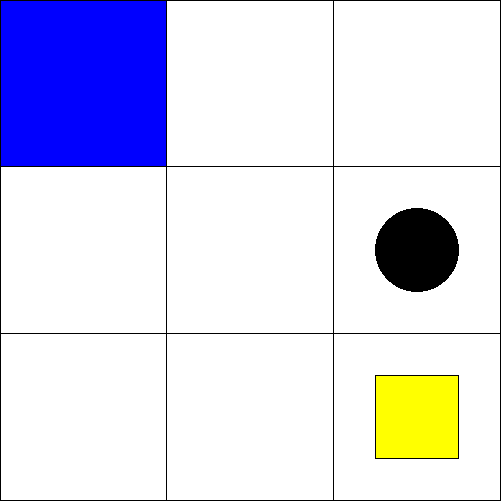

Player's position (1, 2)
Player's possible moves:  [(0, 2), (1, 1), (2, 2), (1, 3)]
Player's chosen move (1, 1)
Player's new position (1, 1)
Player's reward for this move -1.0
Number of moves made to perform task:  44


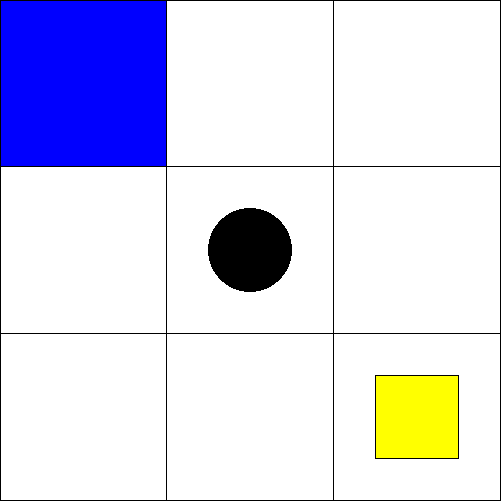

Player's position (1, 1)
Player's possible moves:  [(0, 1), (1, 0), (2, 1), (1, 2)]
Player's chosen move (1, 2)
Player's new position (1, 2)
Player's reward for this move -1.0
Number of moves made to perform task:  45


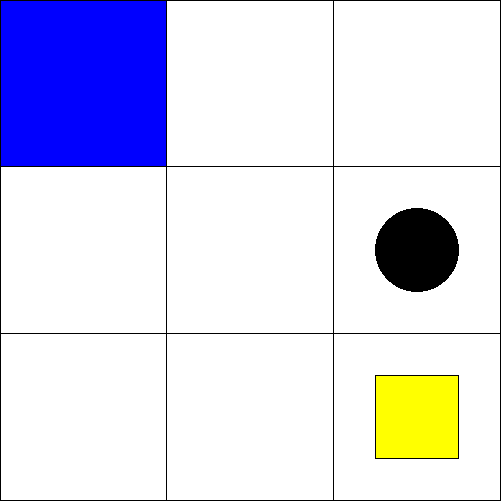

Player's position (1, 2)
Player's possible moves:  [(0, 2), (1, 1), (2, 2), (1, 3)]
Player's chosen move (2, 2)
Player's new position (2, 2)
Player's reward for this move 0.0
Number of moves made to perform task:  46


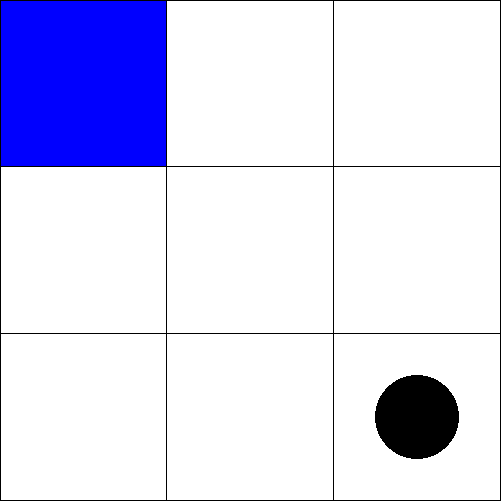

Player finished task in : 46  moves
Player scores for every episode:  [-160020.0, -160028.0]


In [7]:
collection_game = Collection_Game( (3,3), (0,0), [(1,1),(2,2)], -1, 0)
play_game(collection_game, 2, output=True)

In [8]:
collection_game.print_board()

[[-1. -1. -1.]
 [-1.  0. -1.]
 [-1. -1.  0.]]


In [9]:
x = [(-1,0),(0,-1),(1,0),(0,1)]
len(x)

4